# Ensamblar y calcular ganancia

### Autor: Federico Picado
### Fecha de última modificación: 28/10/2024
### Descripción:

Podemos evaluar la ganancia de un modelo en particular, ordenado de distinta forma.
Tambien podemos realizar ensambles entre modelos y evaluar su ganancia. 

## Parámetros

## Input

In [1]:
# Ya en el input se ejecutan cosas
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
import time
from sklearn.metrics import roc_curve, auc, confusion_matrix, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

In [2]:
base_path = '/home/fedepicado/'
modelos_path = base_path + 'buckets/b1/exp/'
predicciones_path = base_path + 'buckets/b1/predicciones/'
db_path = base_path + 'buckets/b1/db/'
dataset_path = base_path + 'buckets/b1/datasets/'
dataset_file = 'Bajas_junio.csv'
full_path = dataset_path + dataset_file

# nombre de la carpeta donde se guardaron los resultados para cada modelo segun la metrica
dataset_folder1="modelo_DQ"


In [3]:
bajas = pd.read_csv(dataset_path + dataset_file)

## Output

< Archivos, bases de datos, modelos que va a generar el job>

In [4]:
# en este ultimo jobs se evalua la performance del modelo.

# MAIN

In [4]:
# Crear un diccionario para almacenar los DataFrames
dataframes = {}

# Función para cargar los CSV de una carpeta específica y asignarlos a variables
def cargar_csv_de_carpeta(dataset_folder):
    folder_path = os.path.join(predicciones_path, dataset_folder)
    for file_name in os.listdir(folder_path):
        if file_name.endswith('.csv'):
            # Nombre de la variable sin extensión
            variable_name = file_name.replace('.csv', '')
            
            # Cargar el DataFrame
            file_path = os.path.join(folder_path, file_name)
            dataframes[variable_name] = pd.read_csv(file_path)
            print(f"Archivo '{file_name}' cargado en la variable '{variable_name}'")

# Cargar los archivos de cada carpeta
cargar_csv_de_carpeta(dataset_folder1)


Archivo 'predicciones_promedio.csv' cargado en la variable 'predicciones_promedio'


In [5]:
dataframes

{'predicciones_promedio':         numero_de_cliente  Probabilidad
 0              1316192480  9.999946e-01
 1              1455026133  9.999888e-01
 2               560453687  9.999843e-01
 3              1317657651  9.999560e-01
 4               651319568  9.998882e-01
 ...                   ...           ...
 164871          757562128  2.720869e-14
 164872         1462779956  2.385668e-14
 164873         1116213561  2.341054e-14
 164874         1330468311  1.255544e-14
 164875         1144881261  8.281588e-15
 
 [164876 rows x 2 columns]}

In [6]:
bajas["clase_ternaria"].value_counts()

clase_ternaria
CONTINUA    162894
BAJA+2        1074
BAJA+1         908
Name: count, dtype: int64

In [7]:
def calculoGanancia(bajas,prediccion,corte):
    ''' 
    Calcula la ganancia para una semilla específica.
    
    Parámetros:
    bajas: DataFrame con columnas "numero_de_cliente" y "clase_ternaria".
    prediccion: DataFrame con columnas "numero_de_cliente" y "Probabilidad".
    corte: int, cantidad de estímulos.
    random_state: int, semilla para train_test_split.
    
    Retorna:
    ganancia_publico: Ganancia para el público.
    ganancia_privado: Ganancia para el privado.
    '''
    # Realizar el split en público y privado
    Publico, Privado = train_test_split(
        bajas,
        test_size=0.7,
        stratify=bajas['clase_ternaria'],
        random_state=123
    )

    # Clientes que decido estimular
    estimulos = prediccion.iloc[:corte] 

    # Obtener los estímulos en el conjunto público y privado
    estimulos_publico = pd.merge(estimulos, Publico, on='numero_de_cliente', how='inner')
    estimulos_privado = pd.merge(estimulos, Privado, on='numero_de_cliente', how='inner')

    # Calcular los verdaderos positivos en cada conjunto
    TP_publico = estimulos_publico[estimulos_publico['clase_ternaria'] == 'BAJA+2']
    TP_privado = estimulos_privado[estimulos_privado['clase_ternaria'] == 'BAJA+2']

    # 5. Calcular la ganancia para cada conjunto con normalización
    # Primero, calculamos la ganancia en cada conjunto
    ganancia_publico_sin_norm = (len(TP_publico) * 273000) - ((len(estimulos_publico) - len(TP_publico)) * 7000)
    ganancia_privado_sin_norm = (len(TP_privado) * 273000) - ((len(estimulos_privado) - len(TP_privado)) * 7000)

    # Luego, normalizamos dividiendo por el porcentaje correspondiente
    ganancia_publico = ganancia_publico_sin_norm / 0.3
    ganancia_privado = ganancia_privado_sin_norm / 0.7

    return ganancia_publico, ganancia_privado

In [8]:
inicio = time.time()

resultados = []
cortes = range(5000, 20000, 1000)

# Iteramos sobre cada modelo en el diccionario de predicciones
for model_name, pred_model in dataframes.items():
    # Aseguramos que las predicciones estén ordenadas por probabilidad descendente
    pred_model_sorted = pred_model.sort_values('Probabilidad', ascending=False)
    
    # Iteramos sobre cada corte
    for corte in cortes:
        ganancia_publico, ganancia_privado = calculoGanancia(bajas, pred_model_sorted, corte)
        
        # Almacenamos los resultados
        resultados.append({
            'Modelo': model_name,
            'Corte': corte,
            'Ganancia Público': ganancia_publico,
            'Ganancia Privado': ganancia_privado
        })

# Convertimos los resultados en un DataFrame
resultados = pd.DataFrame(resultados)

fin = time.time()
tiempo_ejecucion = fin - inicio

print(f"Tiempo de ejecución: {tiempo_ejecucion:.2f} segundos")


Tiempo de ejecución: 2.41 segundos


In [9]:
resultados

,Modelo,Corte,Ganancia Público,Ganancia Privado
0,predicciones_promedio,5000,7.151667e+07,70150000.0
1,predicciones_promedio,6000,7.676667e+07,75500000.0
2,predicciones_promedio,7000,7.987000e+07,80970000.0
3,predicciones_promedio,8000,8.143333e+07,80700000.0
4,predicciones_promedio,9000,8.099000e+07,78490000.0
5,predicciones_promedio,10000,8.677667e+07,82810000.0
6,predicciones_promedio,11000,8.505000e+07,81950000.0
7,predicciones_promedio,12000,8.386000e+07,82060000.0
8,predicciones_promedio,13000,8.596000e+07,82360000.0
9,predicciones_promedio,14000,8.138667e+07,77920000.0


In [14]:
# Pivotamos el DataFrame 'resultados' para reorganizar las ganancias
resultados_pivot = resultados.pivot_table(
    index='Corte',
    columns='Modelo',
    values=['Ganancia Público', 'Ganancia Privado']
)

# Aplanamos las columnas para facilitar el acceso
resultados_pivot.columns = [f'{ganancia}_{modelo}' for ganancia, modelo in resultados_pivot.columns]

# Reordenamos las columnas alternando 'Público' y 'Privado' para cada modelo
# Ordenamos primero por el modelo, luego alternando entre 'Público' y 'Privado'
columnas_ordenadas = []
for modelo in resultados['Modelo'].unique():
    columnas_ordenadas.append(f'Ganancia Público_{modelo}')
    columnas_ordenadas.append(f'Ganancia Privado_{modelo}')

# Reorganizamos el DataFrame usando el nuevo orden de columnas
resultados_pivot = resultados_pivot[columnas_ordenadas]

# Convertimos el índice 'Corte' en una columna si prefieres tenerla como tal
resultados_pivot = resultados_pivot.reset_index()
resultados_pivot

,Corte,Ganancia Público_predicciones_promedio,Ganancia Privado_predicciones_promedio
0,5000,7.569333e+07,68360000.0
1,6000,8.274000e+07,72940000.0
2,7000,8.607667e+07,78310000.0
3,8000,8.449000e+07,79390000.0
4,9000,8.488667e+07,76820000.0
5,10000,8.955333e+07,81620000.0
6,11000,8.953000e+07,80030000.0
7,12000,8.803667e+07,80270000.0
8,13000,8.759333e+07,81660000.0
9,14000,8.463000e+07,76530000.0


## Tengo el problema que segun la semilla con la que dividi el publico privado me puede dar distinto.. hago semillero

In [15]:
def calculoGanancia(bajas, prediccion, corte, random_state):
    ''' 
    Calcula la ganancia para una semilla específica.
    
    Parámetros:
    bajas: DataFrame con columnas "numero_de_cliente" y "clase_ternaria".
    prediccion: DataFrame con columnas "numero_de_cliente" y "Probabilidad".
    corte: int, cantidad de estímulos.
    random_state: int, semilla para train_test_split.
    
    Retorna:
    ganancia_publico: Ganancia normalizada para el conjunto público.
    ganancia_privado: Ganancia normalizada para el conjunto privado.
    '''
    # Realizar el split en público y privado
    Publico, Privado = train_test_split(
        bajas,
        test_size=0.7,
        stratify=bajas['clase_ternaria'],
        random_state=random_state
    )

    # Obtener los estímulos según el modelo
    estimulos = prediccion.iloc[:corte] 

    # Obtener los estímulos en el conjunto público y privado
    estimulos_publico = pd.merge(estimulos, Publico, on='numero_de_cliente', how='inner')
    estimulos_privado = pd.merge(estimulos, Privado, on='numero_de_cliente', how='inner')

    # Calcular los verdaderos positivos en cada conjunto
    TP_publico = estimulos_publico[estimulos_publico['clase_ternaria'] == 'BAJA+2']
    TP_privado = estimulos_privado[estimulos_privado['clase_ternaria'] == 'BAJA+2']

    # Calcular la ganancia para cada conjunto con normalización
    ganancia_publico_sin_norm = (len(TP_publico) * 273000) - ((len(estimulos_publico) - len(TP_publico)) * 7000)
    ganancia_privado_sin_norm = (len(TP_privado) * 273000) - ((len(estimulos_privado) - len(TP_privado)) * 7000)

    # Normalizamos dividiendo por el porcentaje correspondiente
    ganancia_publico = ganancia_publico_sin_norm / 0.3
    ganancia_privado = ganancia_privado_sin_norm / 0.7

    return ganancia_publico, ganancia_privado

def calculoGananciaPromedio(bajas, prediccion, corte, n_seeds=100):
    '''
    Calcula la ganancia promedio para múltiples semillas.
    
    Parámetros:
    bajas: Df con columnas "numero_de_cliente" y "clase_ternaria".
    prediccion: Df con columnas "numero_de_cliente" y "Probabilidad".
    corte: int, cantidad de estímulos.
    n_seeds: int, número de semillas aleatorias (por defecto 200).
    
    Retorna:
    promedio_ganancia_publico: Ganancia promedio normalizada para el conjunto público.
    promedio_ganancia_privado: Ganancia promedio normalizada para el conjunto privado.
    '''
    
    seeds = np.random.randint(1000, 100001, size=n_seeds)
    ganancias_publico = []
    ganancias_privado = []

    for seed in seeds:
        ganancia_publico, ganancia_privado = calculoGanancia(bajas, prediccion, corte, random_state=seed)
        ganancias_publico.append(ganancia_publico)
        ganancias_privado.append(ganancia_privado)

    promedio_ganancia_publico = np.mean(ganancias_publico)
    promedio_ganancia_privado = np.mean(ganancias_privado)

    return promedio_ganancia_publico,promedio_ganancia_privado


In [16]:
inicio = time.time()

resultados = []
cortes = range(5000, 20000, 1000)

# Iteramos sobre cada modelo en el diccionario de predicciones
for model_name, pred_model in dataframes.items():
    # Aseguramos que las predicciones estén ordenadas por probabilidad descendente
    pred_model_sorted = pred_model.sort_values('Probabilidad', ascending=False)
    
    # Iteramos sobre cada corte
    for corte in cortes:
        ganancia_publico, ganancia_privado = calculoGananciaPromedio(bajas, pred_model_sorted, corte)
        
        # Almacenamos los resultados
        resultados.append({
            'Modelo': model_name,
            'Corte': corte,
            'Ganancia Público': ganancia_publico,
            'Ganancia Privado': ganancia_privado
        })

# Convertimos los resultados en un DataFrame
resultados = pd.DataFrame(resultados)

fin = time.time()
tiempo_ejecucion = fin - inicio

print(f"Tiempo de ejecución: {tiempo_ejecucion:.2f} segundos")

Tiempo de ejecución: 228.71 segundos


In [17]:
# Pivotamos el DataFrame 'resultados' para reorganizar las ganancias
resultados_pivot = resultados.pivot_table(
    index='Corte',
    columns='Modelo',
    values=['Ganancia Público', 'Ganancia Privado']
)

# Aplanamos las columnas para facilitar el acceso
resultados_pivot.columns = [f'{ganancia}_{modelo}' for ganancia, modelo in resultados_pivot.columns]

# Reordenamos las columnas alternando 'Público' y 'Privado' para cada modelo
# Ordenamos primero por el modelo, luego alternando entre 'Público' y 'Privado'
columnas_ordenadas = []
for modelo in resultados['Modelo'].unique():
    columnas_ordenadas.append(f'Ganancia Público_{modelo}')
    columnas_ordenadas.append(f'Ganancia Privado_{modelo}')

# Reorganizamos el DataFrame usando el nuevo orden de columnas
resultados_pivot = resultados_pivot[columnas_ordenadas]

# Convertimos el índice 'Corte' en una columna si prefieres tenerla como tal
resultados_pivot = resultados_pivot.reset_index()
resultados_pivot

,Corte,Ganancia Público_predicciones_promedio,Ganancia Privado_predicciones_promedio
0,5000,7.108990e+07,70332900.0
1,6000,7.514243e+07,76196100.0
2,7000,7.994280e+07,80938800.0
3,8000,8.137220e+07,80726200.0
4,9000,7.744917e+07,80007500.0
5,10000,8.324003e+07,84325700.0
6,11000,8.183327e+07,83328600.0
7,12000,8.241263e+07,82680300.0
8,13000,8.449513e+07,82987800.0
9,14000,8.065983e+07,78231500.0


In [18]:
bajas

,numero_de_cliente,clase_ternaria
928963,249221109,CONTINUA
290425,249221468,CONTINUA
3394700,249223005,CONTINUA
4347428,249228180,CONTINUA
3228864,249232117,CONTINUA
...,...,...
2368565,1598444941,CONTINUA
1817623,1598471047,CONTINUA
650981,1598515897,CONTINUA
865535,1598517059,CONTINUA


In [19]:
dataframes

{'predicciones_promedio':         numero_de_cliente  Probabilidad
 0              1316192480  9.999946e-01
 1              1455026133  9.999888e-01
 2               560453687  9.999843e-01
 3              1317657651  9.999560e-01
 4               651319568  9.998882e-01
 ...                   ...           ...
 164871          757562128  2.720869e-14
 164872         1462779956  2.385668e-14
 164873         1116213561  2.341054e-14
 164874         1330468311  1.255544e-14
 164875         1144881261  8.281588e-15
 
 [164876 rows x 2 columns]}

In [23]:
def generar_curvas_roc_multiples(dataframes, bajas, punto_corte):
    """
    Genera curvas ROC para múltiples modelos con un punto de corte específico.
    
    Args:
        dataframes (dict): Diccionario de DataFrames con predicciones 
        bajas (DataFrame): DataFrame con clases reales
        punto_corte (int): Número de clientes a seleccionar
    
    Returns:
        dict: Resultados detallados por modelo
    """
    resultados = {}
    
    plt.figure(figsize=(10, 6))
    
    for model_name, pred_model in dataframes.items():
        # Merge predictions with actual classes
        merged_data = pred_model.merge(bajas, on='numero_de_cliente', how='inner')
        
        # Ordenar por probabilidad de mayor a menor
        merged_data_sorted = merged_data.sort_values('Probabilidad', ascending=False)
        
        # Seleccionar top clientes
        top_clients = merged_data_sorted.iloc[:punto_corte].copy()  # Trabajar con una copia
        
        # Convertir 'clase_ternaria' a variable binaria para los top clientes
        top_clients.loc[:, 'bajas_reales'] = (top_clients['clase_ternaria'] == 'BAJA+2').astype(int)
        
        # Compute ROC curve and AUC usando solo los top clientes
        fpr, tpr, thresholds = roc_curve(top_clients['bajas_reales'], top_clients['Probabilidad'])
        roc_auc = auc(fpr, tpr)
        
        # Métricas para los top clients
        vp = top_clients[top_clients['bajas_reales'] == 1].shape[0]
        fp = top_clients[top_clients['bajas_reales'] == 0].shape[0]
        
        # Total de bajas reales
        total_bajas = merged_data[merged_data['clase_ternaria'] == 'BAJA+2'].shape[0]
        
        # Almacenar resultados
        resultados[model_name] = {
            'FPR': fpr,
            'TPR': tpr,
            'AUC': roc_auc,
            'VP': vp,
            'FP': fp,
            'Total_Bajas_Reales': total_bajas,
            'Tasa_VP': vp / total_bajas if total_bajas > 0 else 0
        }
        
        # Plot ROC curve
        plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')
    
    # Configuración del gráfico ROC
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random')
    plt.xlabel('Tasa de Falsos Positivos (FPR)')
    plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
    plt.title(f'Curvas ROC por Modelo (Corte: {punto_corte} clientes)')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()
    
    return resultados


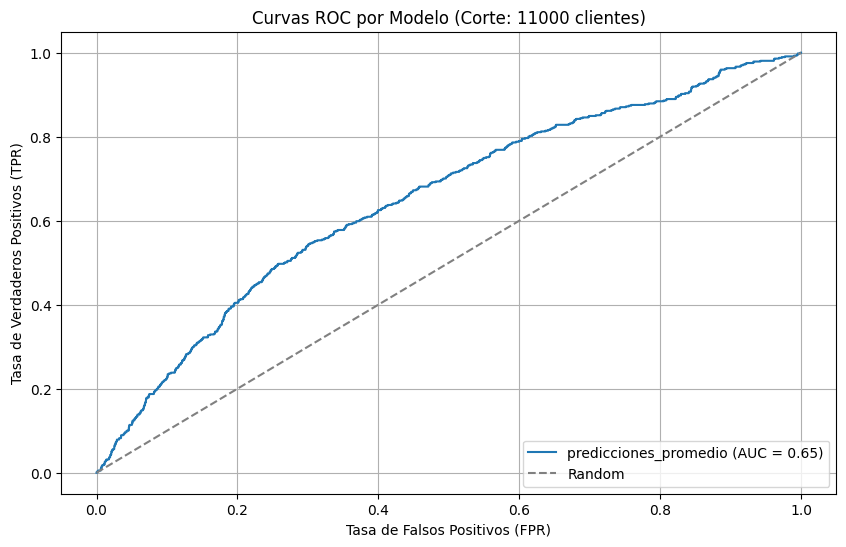

{'predicciones_promedio': {'FPR': array([0.00000000e+00, 9.58864704e-05, 1.15063765e-03, ...,
         9.98945249e-01, 9.98945249e-01, 1.00000000e+00]),
  'TPR': array([0.        , 0.        , 0.        , ..., 0.99824869, 1.        ,
         1.        ]),
  'AUC': np.float64(0.6494736571653978),
  'VP': 571,
  'FP': 10429,
  'Total_Bajas_Reales': 1074,
  'Tasa_VP': 0.5316573556797021}}

In [33]:
generar_curvas_roc_multiples(dataframes,bajas,11000)